In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D,MaxPooling2D, MaxPool2D, Flatten, Activation, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np

import os, shutil


In [2]:
# # 分拆成訓練、驗證與測試目錄位置
train_dir = "/home/kuo232/pneu_data/abnormal_croped/train_data"
if not os.path.isdir(train_dir): os.mkdir(train_dir)

test_dir = "/home/kuo232/pneu_data/abnormal_croped/test_data"
if not os.path.isdir(test_dir): os.mkdir(test_dir)


train_true_dir = "/home/kuo232/pneu_data/abnormal_croped/train_data/true"
if not os.path.isdir(train_true_dir): 
    os.mkdir(train_true_dir)

train_false_dir = "/home/kuo232/pneu_data/abnormal_croped/train_data/false"
if not os.path.isdir(train_false_dir): 
    os.mkdir(train_false_dir)

test_true_dir = "/home/kuo232/pneu_data/abnormal_croped/test_data/true"
if not os.path.isdir(test_true_dir): 
    os.mkdir(test_true_dir) 

test_false_dir = "/home/kuo232/pneu_data/abnormal_croped/test_data/false"
if not os.path.isdir(test_false_dir): 
    os.mkdir(test_false_dir)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255) #設定訓練、測試資料的 Python 產生器，並將圖片像素值依 1/255 比例重新壓縮到 [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,              # 目標目錄
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    color_mode="grayscale")    # 因為使用二元交叉熵 binary_crossentropy 作為損失值，所以需要二位元標籤


validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    color_mode="grayscale")


Found 5066 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


In [46]:
def pretrained_VGG19(width, height, depth):
    input_layer = tf.keras.Input(shape=(width, height, depth))
    input_conc = concatenate([input_layer, input_layer, input_layer])
    base_model = VGG19(input_tensor = input_conc,weights = 'imagenet',include_top = False)

    flat_v = Flatten()(base_model.output)
    dense1 = Dense(64, activation='relu')(flat_v)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense2)
    model = Model(input_layer, output_layer)
    return model

VGG19_Model = pretrained_VGG19(128, 128, 1)
VGG19_Model.summary()

VGG19_Model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history = VGG19_Model.fit_generator(
    train_generator,
    steps_per_epoch=387,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=180)

from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
print("date and time =", dt_string)	

model_name = dt_string + ".h5"
VGG19_Model.save(model_name)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        concatenate[0][0]                
______________________________________________________________________________________________

now = 2019-11-20 23:50:37.545039
date and time = 20_11_2019_23_50_37


In [6]:
# from PIL import Image
# import glob, os
# import numpy as np

# base_folder = './testing/true'
# # image = Image.open(os.path.join(base_folder,'/1.png'))
# image = Image.open("./testing/true/1.png").convert('L')
# image = image.resize((512,512))
# # label = label.resize((512,512))
# all_croped_image = []
# for y in range(12):
#     for x in range(12):
#         box = (x*32,y*32,x*32+128,y*32+128)
#         croped_image = image.crop(box)
#         croped_image = np.array(croped_image)
#         croped_image = croped_image.reshape((128,128,1))
#         all_croped_image.append(croped_image)
      
# all_croped_image = np.array(all_croped_image)
# print(all_croped_image.shape)

(144, 128, 128, 1)


In [35]:
model = load_model('128_128_1.h5')

In [36]:
from PIL import Image, ImageDraw

def crop_image(image):
    result = list()
    for y in range(12):
        for x in range(12):
            croped = image.crop((x*32, y*32, x*32+128, y*32+128))
            result.append(np.array(croped).reshape(128,128,1)/255)
    return np.array(result)

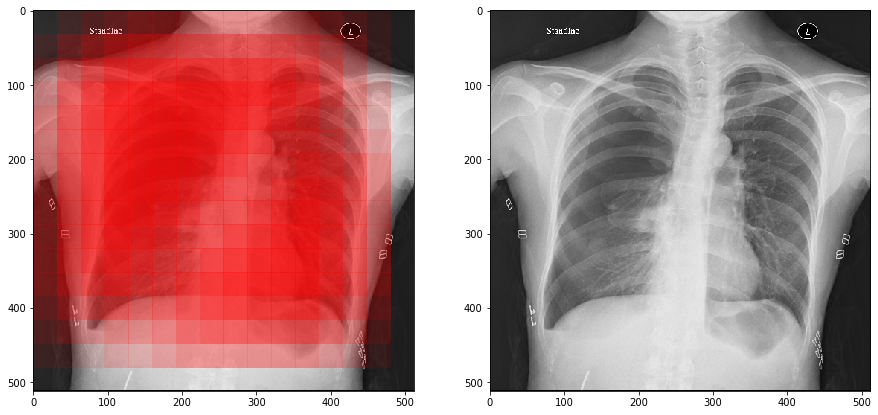

In [42]:
from matplotlib.pyplot import imshow
%matplotlib inline
image = Image.open("./testing/true/5.png").convert('RGBA')
# image = Image.open("./1_pure_pneumothorax/0001-I0000163.png").convert('RGBA')
# image = Image.open("./DATASET/1_pure_pneumothorax/0001-I0000158.png").convert('RGBA')

image = image.resize((512,512))
ori = image
image_grayscale = image.convert('L')

croped = crop_image(image_grayscale)
predict = model.predict(croped)
predict = np.where(predict > 0.5, 1 ,0)

TINT_COLOR = (255, 0, 0)  # Black
TRANSPARENCY = 0.1  # Degree of transparency, 0-100%
OPACITY = int(255 * TRANSPARENCY)
for y in range(12):
    for x in range(12):
        bbox = ((x*32, y*32, x*32+128, y*32+128))
        if(predict[x+y][0] == 1):
            overlay = Image.new('RGBA', image.size, TINT_COLOR+(0,))
            draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
            draw.rectangle(bbox, fill=TINT_COLOR+(OPACITY,))
            image = Image.alpha_composite(image, overlay)
            
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(np.array(image))

fig.add_subplot(1,2,2)
plt.imshow(np.array(ori))

In [34]:
history

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D,MaxPooling2D, MaxPool2D, Flatten, Activation, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np

import os, shutil
model = load_model('128_128_1.h5')
from PIL import Image, ImageDraw

def crop_image(image):
    result = list()
    for y in range(12):
        for x in range(12):
            croped = image.crop((x*32, y*32, x*32+128, y*32+128))
            result.append(np.array(cr

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline
# image = Image.open("./testing/true/5.png").convert('RGBA')
# image = Image.open("./1_pure_pneumothorax/0001-I0000163.png").convert('RGBA')
image = Image.open("./1_pure_pneumothorax/0001-I0000158.png").convert('RGBA')

# image = Image.open("./testing/false/0001-I0149552.png").convert('RGBA')
image = image.resize((512,512))
temp = image
image_grayscale = image.convert('L')

croped = np.ceil(crop_image(image_grayscale))
croped = 255 - croped
predict = model.predict(croped)
predict = np.where(predict > 0.5, 1 ,0)

TINT_COLOR = (255, 0, 0)  # Black
TRANSPARENCY = 0.1  # Degree of transparency, 0-100%
OPACITY = int(255 * TRANSPARENCY)
for y in range(12):
    for x in range(12):
        bbox = ((x*32, y*32, x*32+128, y*32+128))
        if(predict[x+y][0] == 1):
            overlay = Image.new('RGBA', image.size, TINT_COLOR+(0,))
            draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
            draw.rectangle(bbox, fill=TINT_COLOR+(OPACITY,))
            image = Image.alpha_composite(image, overlay)
            
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(np.array(image))
